In [1]:
from IPython.display import *

# Setup Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import *

# Setup numpy, pandas
import pandas as pd
import numpy as np

# Setup matplotlib
import matplotlib
import matplotlib.pyplot as plt
DEFAULT_W, DEFAULT_H = (16, 9)
matplotlib.rcParams["figure.figsize"] = [DEFAULT_W, DEFAULT_H]
matplotlib.rcParams["font.size"] = 15
matplotlib.rcParams['figure.dpi'] = 100

# Load data
FILE_NAME = "winequality_white.csv"
Y_COL_NAME = "quality"
data = pd.read_csv(FILE_NAME, sep=";")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# I Stats

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.00,-0.02,0.29,0.09,0.02,-0.05,0.09,0.27,-0.43,-0.02,-0.12,-0.11
volatile acidity,-0.02,1.00,-0.15,0.06,0.07,-0.10,0.09,0.03,-0.03,-0.04,0.07,-0.19
citric acid,0.29,-0.15,1.00,0.09,0.11,0.09,0.12,0.15,-0.16,0.06,-0.08,-0.01
residual sugar,0.09,0.06,0.09,1.00,0.09,0.30,0.40,0.84,-0.19,-0.03,-0.45,-0.10
chlorides,0.02,0.07,0.11,0.09,1.00,0.10,0.20,0.26,-0.09,0.02,-0.36,-0.21
free sulfur dioxide,-0.05,-0.10,0.09,0.30,0.10,1.00,0.62,0.29,-0.00,0.06,-0.25,0.01
total sulfur dioxide,0.09,0.09,0.12,0.40,0.20,0.62,1.00,0.53,0.00,0.13,-0.45,-0.17
density,0.27,0.03,0.15,0.84,0.26,0.29,0.53,1.00,-0.09,0.07,-0.78,-0.31
pH,-0.43,-0.03,-0.16,-0.19,-0.09,-0.00,0.00,-0.09,1.00,0.16,0.12,0.10
sulphates,-0.02,-0.04,0.06,-0.03,0.02,0.06,0.13,0.07,0.16,1.00,-0.02,0.05


fixed acidity          -0.113663
volatile acidity       -0.194723
citric acid            -0.009209
residual sugar         -0.097577
chlorides              -0.209934
free sulfur dioxide     0.008158
total sulfur dioxide   -0.174737
density                -0.307123
pH                      0.099427
sulphates               0.053678
alcohol                 0.435575
Name: quality, dtype: float64

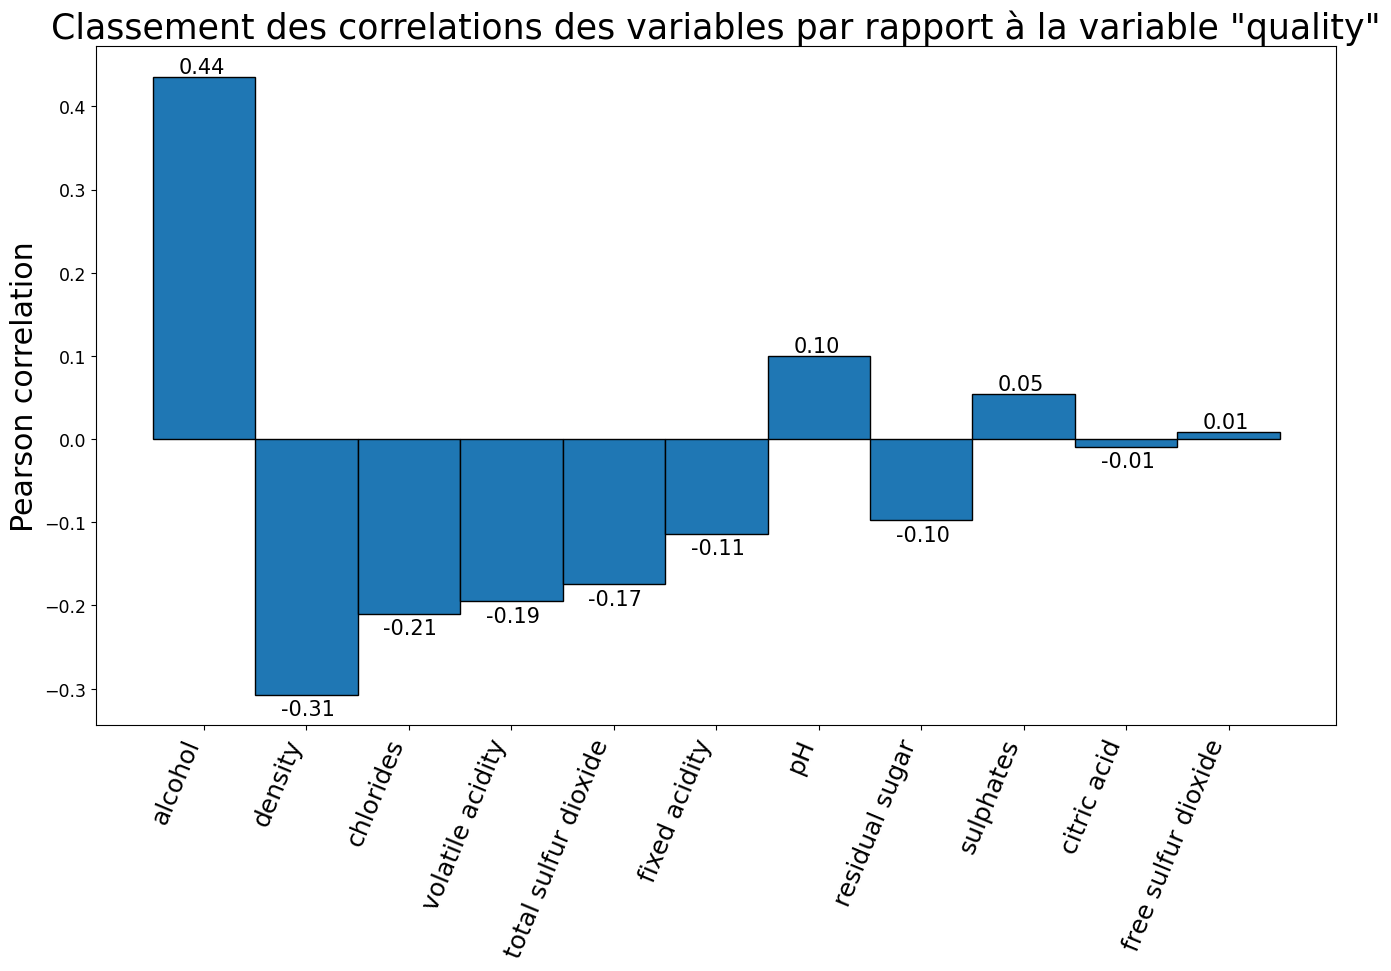

In [2]:
# TODO
# - distribution
# - (FAIT) matrice de correlation (pearson correlation)
# std, mean, boite moustache etc...
# distribution par note

data.describe()

corr = data.corr(method='pearson')
display(corr.style.background_gradient(cmap='coolwarm').set_precision(2))
# classement:
# top = abs(corr.loc[Y_COL_NAME]).sort_values(ascending=False)
top = corr.loc[Y_COL_NAME][corr.index != Y_COL_NAME]
sorted = abs(top).sort_values(ascending=False)
display(top) # en abs car -1 donne une bonne correlation aussi (correlation negative)
fig, ax = plt.subplots()
ax.bar(x=sorted.index, height=top[sorted.index], width=1, edgecolor='black')
ax.set_title("Classement des correlations des variables par rapport à la variable \"quality\"", fontdict={"size":25})
for i, v in enumerate(top[sorted.index].values):
    ax.text(i - 0.25, (v + np.sign(v) * 0.015) - 0.01, f"{round(v, 2):.2f}", color='black')
# plt.axhline(1, linestyle='--')
# plt.axhline(-1, linestyle='--')
plt.ylabel("Pearson correlation", fontweight='light', fontsize='x-large')
plt.xticks(rotation=67.5, horizontalalignment='right', fontweight='light', fontsize='large')
plt.yticks(fontweight='light', fontsize='small')
plt.show()

# II. Data preparation

In [3]:
NB_CLASS = 10

X = data.loc[:, data.columns != Y_COL_NAME]
# X = ((X - X.mean()) / X.std()).values # Standardization colonne par colonne # (x - µ) / σ
# ou
X = ((X - X.min()) / (X.max() - X.min())).values # min-max scaling => 0 - 1 # (x - min) / (max - min)
# Jmais compris c'etait quoi le mieux : https://kharshit.github.io/blog/2018/03/23/scaling-vs-normalization

Y = data.loc[:, Y_COL_NAME].values
Y = Y.reshape(-1, 1) # Y est scale entre 0 et 1 au moment de faire la regression (on garde les notes en entier pour le model de classif)

NB_INPUT = X.shape[1] # nombre de variable en input des modeles
NB_DATA = X.shape[0]
# X, Y, X.shape, Y.shape

# Split train/test/validation
pTrain, pTest, pValidation = (0.80, 0.10, 0.10)
assert (pTrain + pTest + pValidation) == 1.0, f"La somme doit etre equel à 1, {pTrain, pTest, pValidation}"
SPLIT_TRAIN = int(NB_DATA * pTrain)
SPLIT_TEST = int(NB_DATA * pTest)
SPLIT_VAL = int(NB_DATA * pValidation)
print(SPLIT_TRAIN, SPLIT_TEST, SPLIT_VAL)
X_train, X_test, X_val = X[:SPLIT_TRAIN], X[SPLIT_TRAIN:SPLIT_TRAIN+SPLIT_TEST], X[-SPLIT_VAL:]
Y_train, Y_test, Y_val = Y[:SPLIT_TRAIN], Y[SPLIT_TRAIN:SPLIT_TRAIN+SPLIT_TEST], Y[-SPLIT_VAL:]
print(X_train.shape, X_test.shape, X_val.shape)
print(Y_train.shape, Y_test.shape, Y_val.shape)

3918 489 489
(3918, 11) (489, 11) (489, 11)
(3918, 1) (489, 1) (489, 1)


# III. Models

In [4]:
def regression_model():
	input = Input(shape=(NB_INPUT,), name="input")
	x = Dense(1000, activation="relu")(input)
	x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	x = Dense(500, activation="relu")(x)
	x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	x = Dense(250, activation="relu")(x)
	x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	# output = Dense(1, activation=ReLU(max_value=1.0), name="prediction")(x)
	output = Dense(1, activation="sigmoid", name="prediction")(x)

	return Model(input, output, name="regression_model")

def classification_model():
	input = Input(shape=(NB_INPUT,), name="input")
	x = Dense(1000, activation="relu")(input)
	x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	x = Dense(500, activation="relu")(x)
	x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	x = Dense(250, activation="relu")(x)
	x = Dropout(0.2)(x)
	x = BatchNormalization()(x)
	output = Dense(NB_CLASS, activation=Softmax(), name="prediction")(x)
	
	return Model(input, output, name="classification_model")

def regression_accuracy(y_true, y_pred):
	y_true = tf.cast(tf.round(y_true * NB_CLASS), dtype=tf.int8)
	y_pred = tf.cast(tf.round(y_pred * NB_CLASS), dtype=tf.int8)
	eq = tf.cast(tf.math.equal(y_true, y_pred), dtype=tf.float16)
	return tf.reduce_mean(eq)

# regression_model().summary()
# classification_model().summary()

# yt, yp = tf.constant([0,1,2,3,4,5,6,7,8,9]) / 10, tf.constant([0.05,0.0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
# print(yt, yp)
# regression_accuracy(yt, yp)

In [24]:
regModel = regression_model()
regModel.compile(loss="mse", metrics=[regression_accuracy], optimizer=Adam(learning_rate=0.0001))
regModel.summary()

hreg = regModel.fit(X_train, Y_train / NB_CLASS, validation_data=[X_test, Y_test / NB_CLASS], batch_size=32, epochs=100)



Model: "regression_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 11)]              0         
                                                                 
 dense_6 (Dense)             (None, 1000)              12000     
                                                                 
 dropout_6 (Dropout)         (None, 1000)              0         
                                                                 
 batch_normalization_6 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 500)               500500    
                                                                 
 dropout_7 (Dropout)         (None, 500)               0         
                                                  

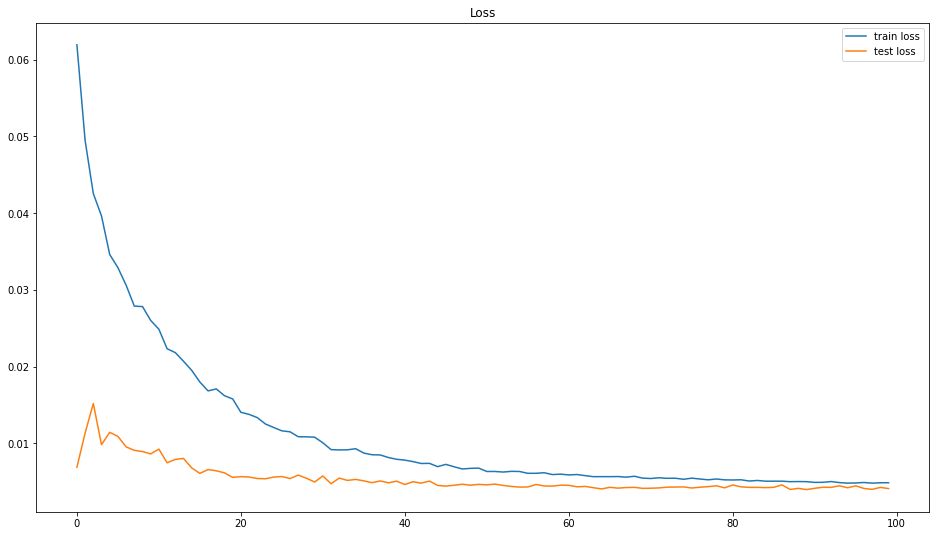

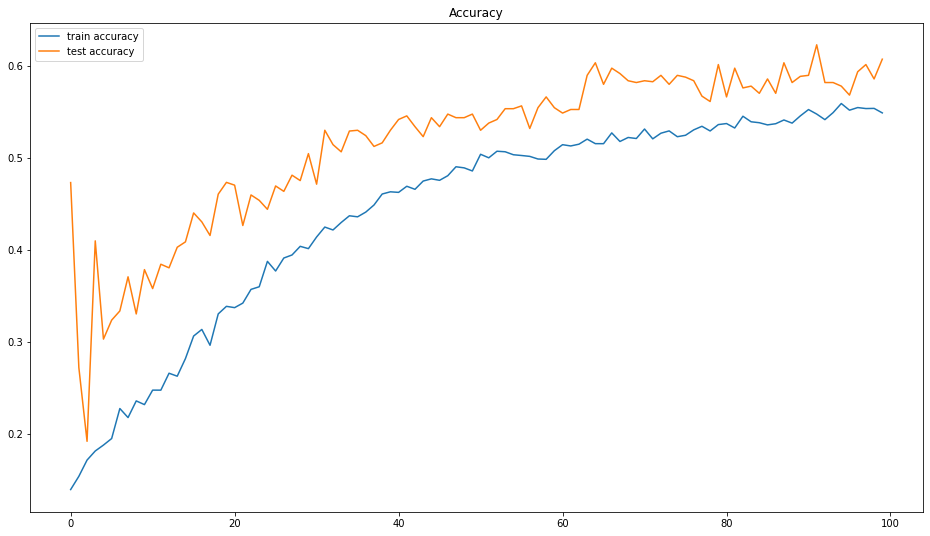

In [25]:
plt.title("Loss")
plt.plot(hreg.history["loss"], label="train loss")
plt.plot(hreg.history["val_loss"], label="test loss")
plt.legend()
plt.show()
plt.title("Accuracy")
plt.plot(hreg.history["regression_accuracy"], label="train accuracy")
plt.plot(hreg.history["val_regression_accuracy"], label="test accuracy")
plt.legend()
plt.show()

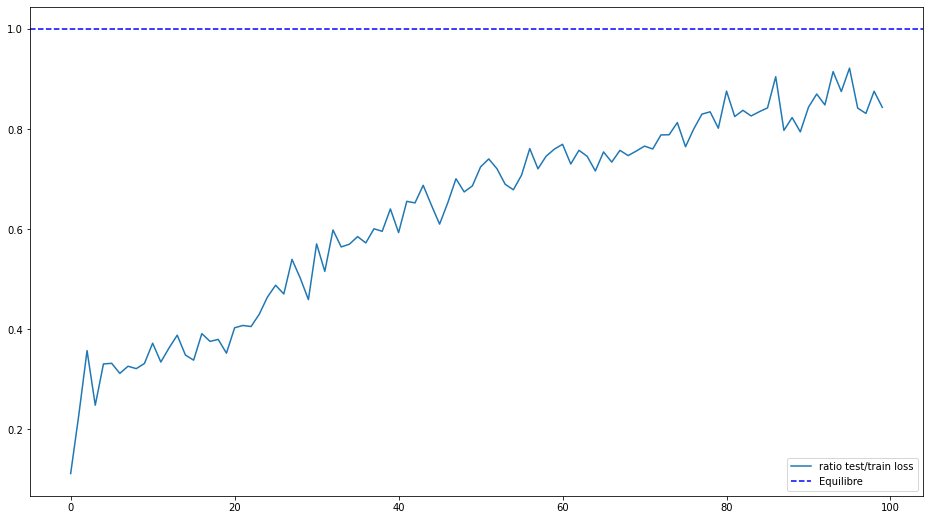

In [40]:
plt.plot(np.array(hreg.history["val_loss"]) / np.array(hreg.history["loss"]), label="ratio test/train loss")
plt.axhline(y=1, color='b', linestyle='--', label="Equilibre")
plt.legend()
# Pour evaluer le surapprentissage (plus on s'eloigne de 1 en positif plus on est en surapprentisssage)
# si on est en dessous de 1 ca veut dire que le modele performe mieux sur le test que le train (c'est plutot normal vu qu'il y a du Dropout dans le model là)

In [5]:
classModel = classification_model()
classModel.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer=Adam(learning_rate=0.0001))
classModel.summary()

hclass = classModel.fit(X_train, Y_train, validation_data=[X_test, Y_test], batch_size=32, epochs=100)

Model: "classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 11)]              0         
                                                                 
 dense (Dense)               (None, 1000)              12000     
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                              

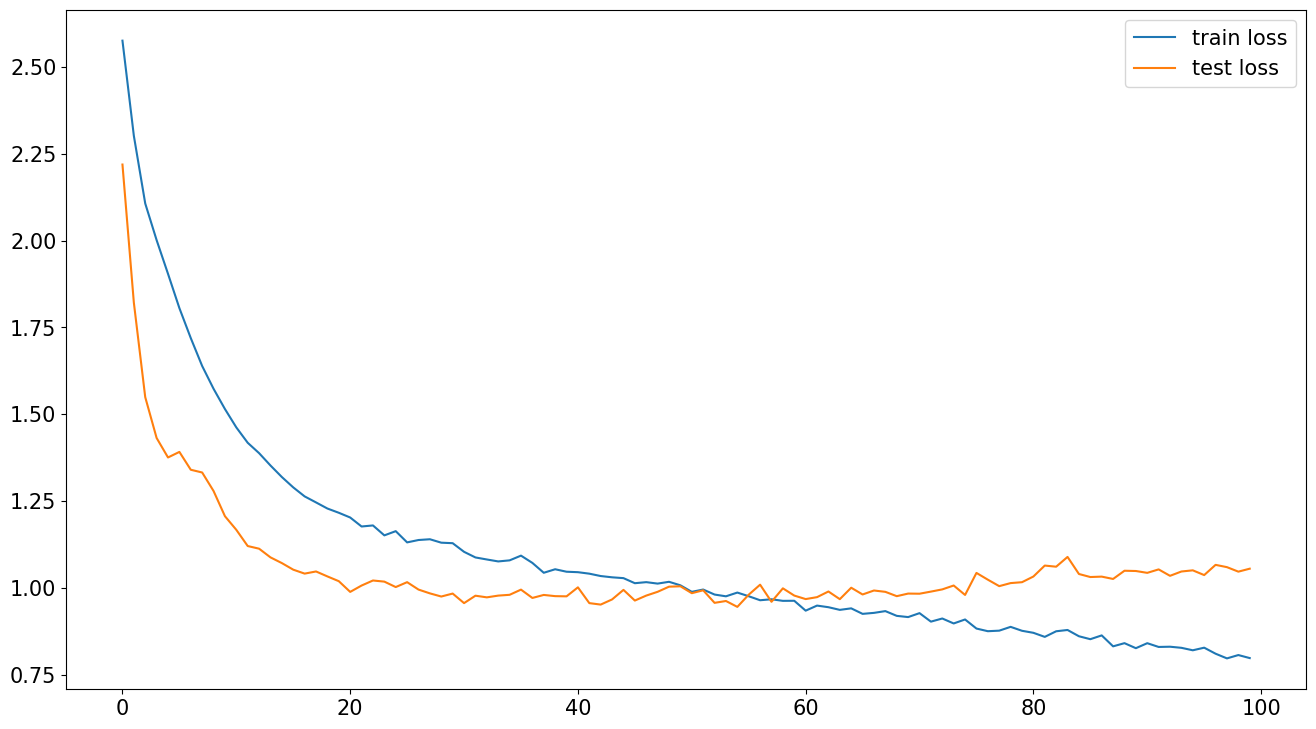

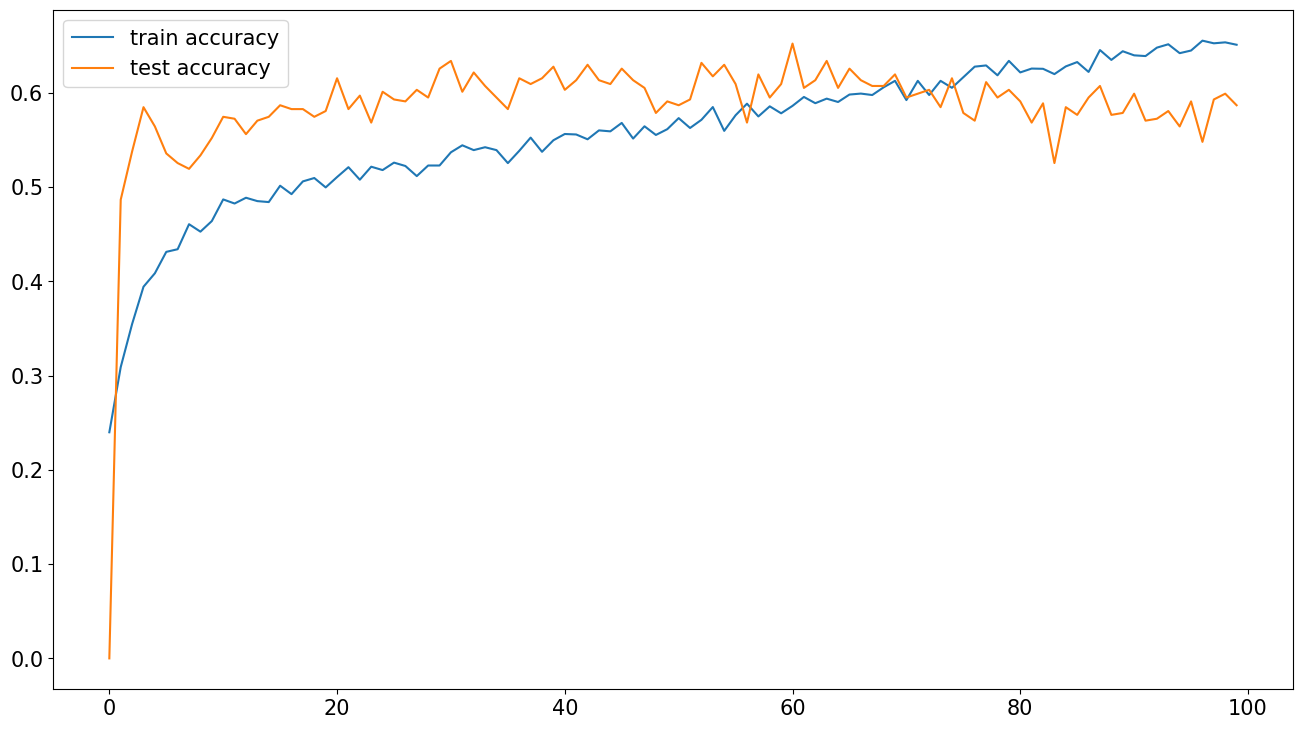

In [6]:
plt.figure(figsize=(16,9))
plt.plot(hclass.history["loss"], label="train loss")
plt.plot(hclass.history["val_loss"], label="test loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,9))
plt.plot(hclass.history["accuracy"], label="train accuracy")
plt.plot(hclass.history["val_accuracy"], label="test accuracy")
plt.legend()
plt.show()

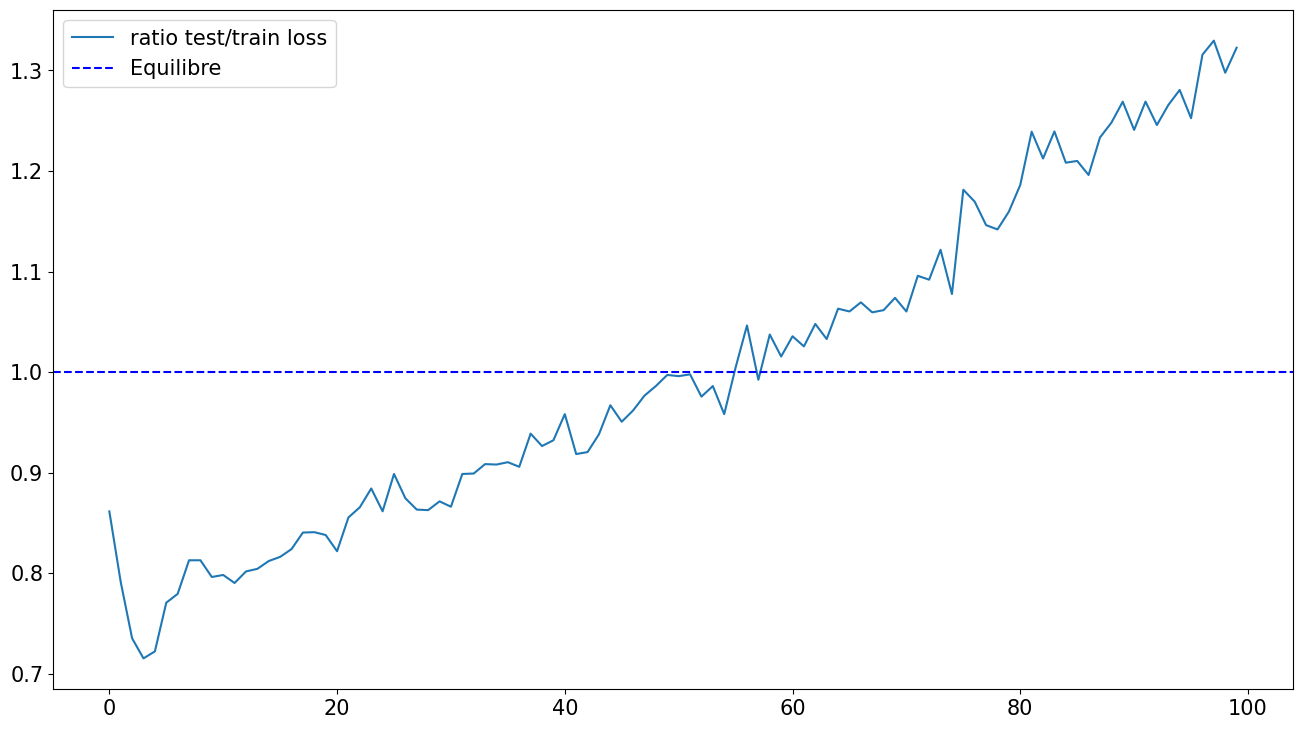

In [7]:
plt.plot(np.array(hclass.history["val_loss"]) / np.array(hclass.history["loss"]), label="ratio test/train loss")
plt.axhline(y=1, color='b', linestyle='--', label="Equilibre")
plt.legend()
# Pour evaluer le surapprentissage (plus on s'eloigne de 1 en positif plus on est en surapprentisssage)

In [28]:
Y_pred, Y_true

(array([6, 6, 6, ..., 8, 7, 5], dtype=int64),
 array([6, 6, 6, ..., 7, 6, 5], dtype=int64))

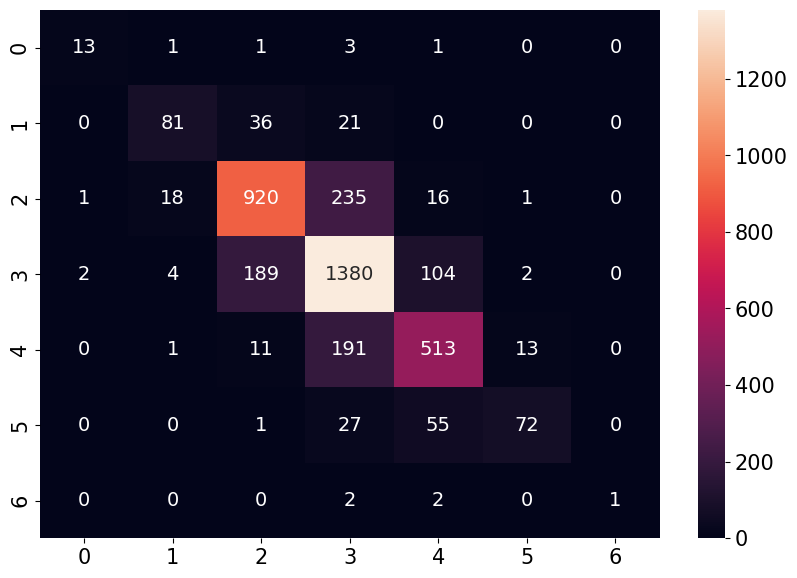

<AxesSubplot:>

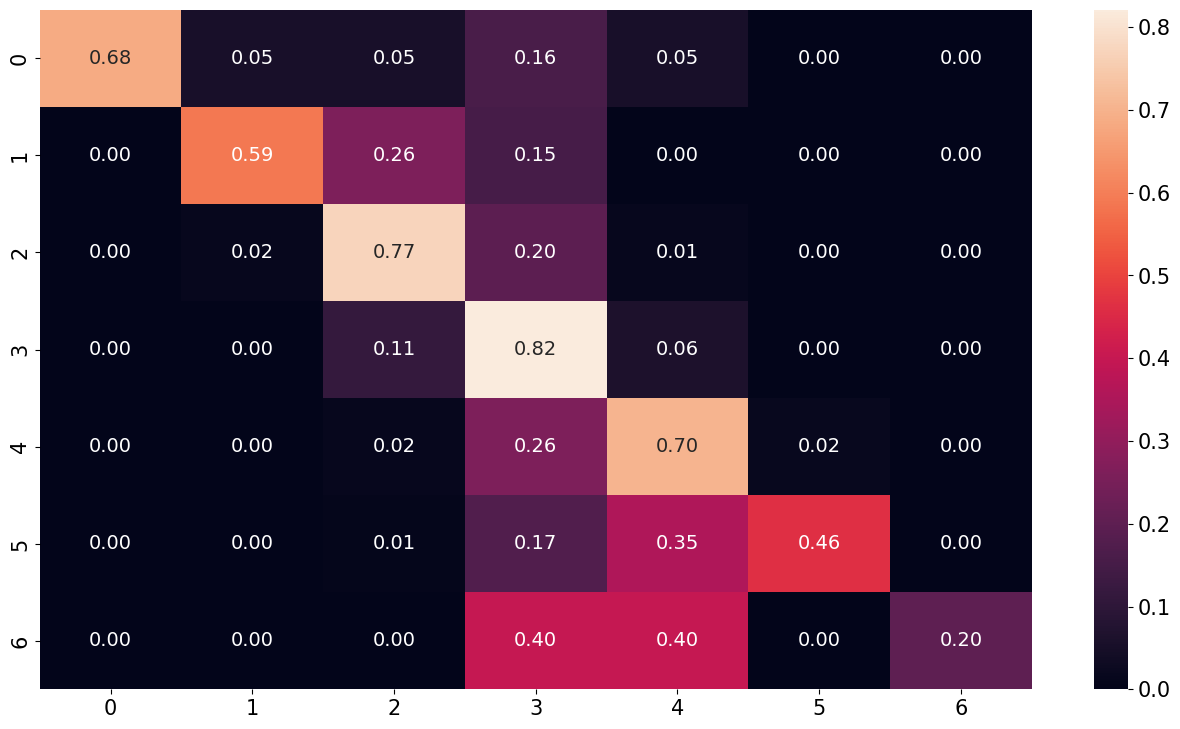

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
Y_pred = np.argmax(classModel.predict(X_train), axis=1)
Y_true = Y_train.reshape(-1,)
cm = confusion_matrix(Y_true, Y_pred, labels=np.unique(Y_true))
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g')
plt.show()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='.2f')

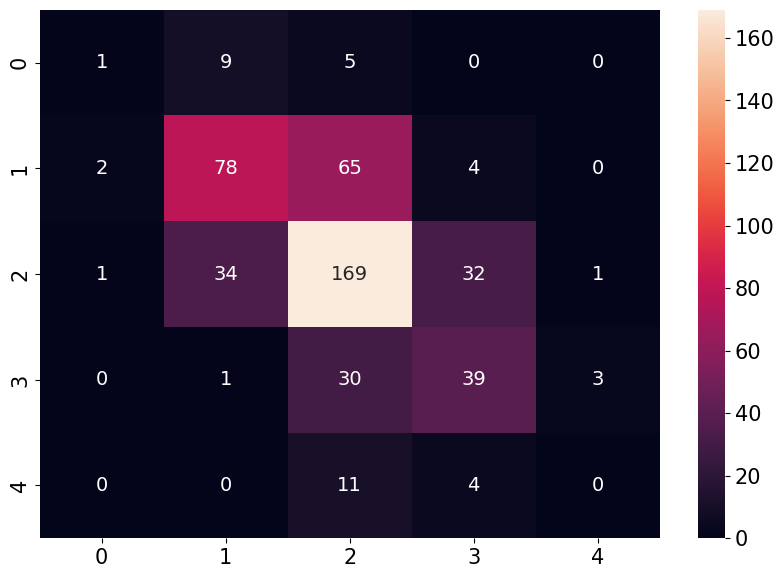

<AxesSubplot:>

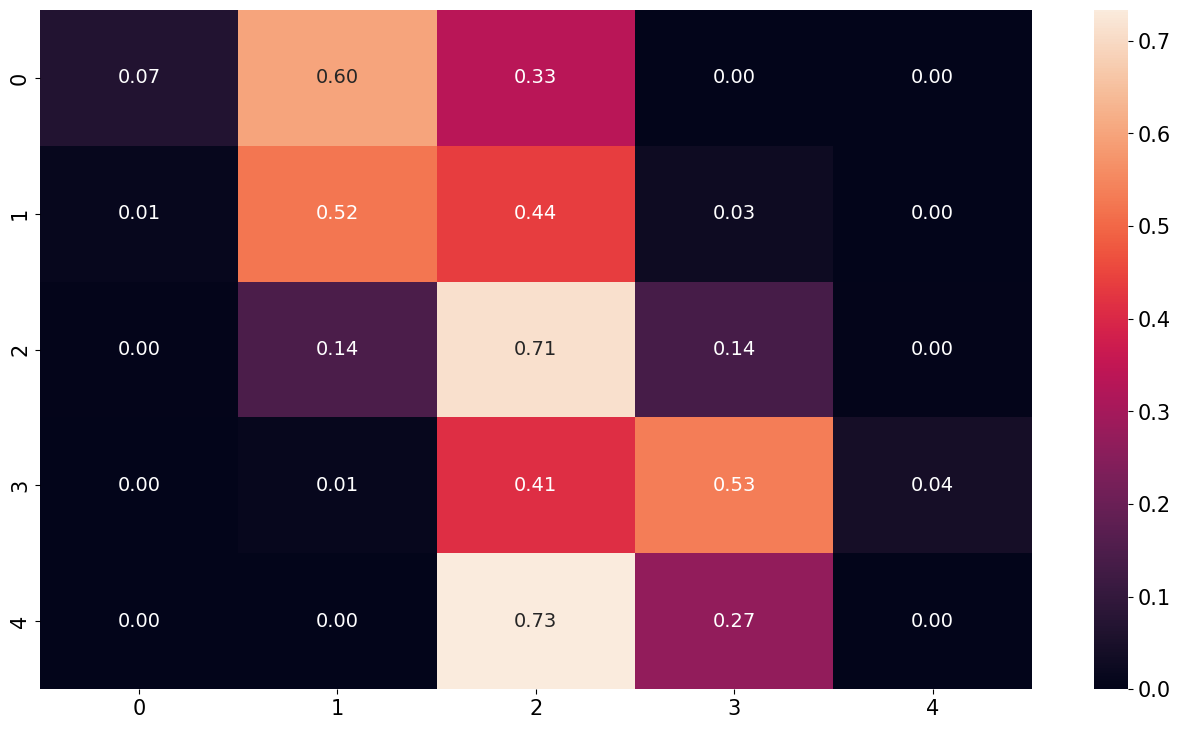

In [57]:
Y_pred = np.argmax(classModel.predict(X_test), axis=1)
Y_true = Y_test.reshape(-1,)
cm = confusion_matrix(Y_true, Y_pred, labels=np.unique(Y_true))
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g')
plt.show()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='.2f')

# IV Evaluations

In [ ]:
# TODO Cross Val pour test different meta parametre
# plot les resultats + leur std par epochs

# TODO tester l'accuracy de la classif en faisant apparaitre aussi le seconde choix du model
# possible aussi de regarder si les deux premier choix sont "proche" (cad si une prediction à 5 en choix 1 est suivit par un 4 ou 6 en choix 2 (faisable en faaisant mean(abs(choix1-choix2)))))

# V Conclusion

In [ ]:
# TODO Conclure
# TODO souligner les limites du dataset: que 3 votants, manque d'element en input comme le prix, les labels de qualité etc pour que le model soit pertinent dans le cadre d'une utilisation de classification de vin en situation de vente reel